In [1]:
import torch
import torch.nn.functional as F 
import torch.optim as optim
import matplotlib.pyplot as plt
#import utils
import models
#import model
from torchsummary import summary
from tqdm import tqdm
import numpy as np
from torch.optim.lr_scheduler import ReduceLROnPlateau
import pdb
import albumentations as A
import DataAugmentations as Aug
import torch.nn as nn

In [2]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

metadata_path = '/Users/mouzam/TSAI/data/cifar-10-batches-py/batches.meta' 
metadata = unpickle(metadata_path)

inttoclasses = {i:classes for  i,classes in  enumerate(metadata[b'label_names'])}

In [3]:
#Mean Train
print(Aug.train_data.data.mean(axis=(0, 1, 2))/255)
#Mean Test
print(Aug.test_data.data.mean(axis=(0, 1, 2))/255)

[0.49139968 0.48215841 0.44653091]
[0.49421428 0.48513139 0.45040909]


In [4]:
#Std Train
print(Aug.train_data.data.std(axis=(0, 1, 2))/255)
#Std test
print(Aug.test_data.data.std(axis=(0, 1, 2))/255)

[0.24703223 0.24348513 0.26158784]
[0.24665252 0.24289226 0.26159238]


In [5]:
training_iterator = iter(Aug.train_loader)

In [6]:
batch_images, batch_labels = next(training_iterator)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

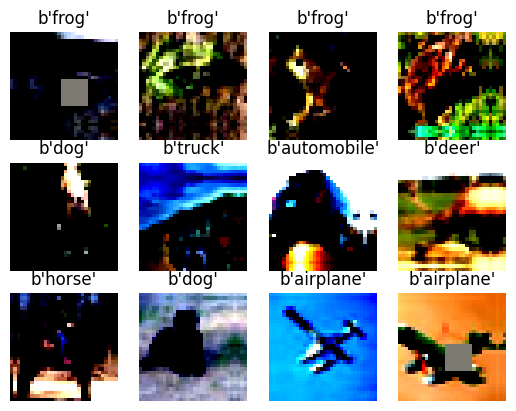

In [7]:

# Print 12 images to see the sample data
for i in range(12):
    plt.subplot(3,4,i+1)
    im = batch_images[i]
    im = np.transpose(im, axes=[1, 2, 0])
    plt.imshow(im)
    plt.title(inttoclasses[batch_labels[i].item()])
    plt.axis('off')

In [3]:

has_mps = getattr(torch,'has_mps',False)
device = "mps" if getattr(torch,'has_mps',False) \
    else "gpu" if torch.cuda.is_available() else "cpu"

In [4]:
def get_lr(optimizer):
    """"
    for tracking how your learning rate is changing throughout training
    """
    for param_group in optimizer.param_groups:
        return param_group['lr']

In [5]:

train_losses = []
test_losses = []
train_acc = []
test_acc = []
lrs = []

def train(model, device, train_loader, optimizer, scheduler,criterion):
  model.train()
  pbar = tqdm(train_loader)
  correct = 0
  processed = 0
 
  for batch_idx, (data, target) in enumerate(pbar):
    # get samples
    #print('Printing batch id -->' + str(batch_idx))
    data, target = data.to(device), target.to(device)

    # Init
    optimizer.zero_grad()
    # In PyTorch, we need to set the gradients to zero before starting to do backpropragation because PyTorch accumulates the gradients on subsequent backward passes. 
    # Because of this, when you start your training loop, ideally you should zero out the gradients so that you do the parameter update correctly.

  
    
    # Backpropagation
    loss.backward()
    optimizer.step()

    scheduler.step()
    # Update pbar-tqdm
    #pdb.set_trace()
    _, pred = torch.max(y_pred.data, 1)
    #pred = y_pred.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
    correct += pred.eq(target.view_as(pred)).sum().item()
    processed += len(data)

    pbar.set_description(desc= f'Loss={loss.item()} Batch_id={batch_idx} Accuracy={100*correct/processed:0.2f}')
    #print(lr)
    train_acc.append(100*correct/processed)

def test(model, device, test_loader,criterion):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            #test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            test_loss += criterion(output, target).item()
            _, pred = torch.max(output.data, 1)
            #pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()
            

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    
    #pdb.set_trace()
    # misclassified_images = data[(pred != target.view_as(pred)).view(-1)]
    # misclassified_images_actual_label = target[(pred != target.view_as(pred)).view(-1)]
    # misclassified_images_predicted_label = pred[(pred != target.view_as(pred)).view(-1)].squeeze(1)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.2f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    # test_acc.append(100. * correct / len(test_loader.dataset))

    return test_loss


In [6]:
device

'mps'

In [7]:
model = models.model().to(device= device)

#model = model.CustomResNet().to(device)

/Users/mouzam/TSAI/.venv/lib/python3.11/site-packages/torch_lr_finder/lr_finder.py:5: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm
 66%|██████▋   | 133/200 [01:15<00:38,  1.75it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()


LR suggestion: steepest gradient
Suggested LR: 2.74E-02


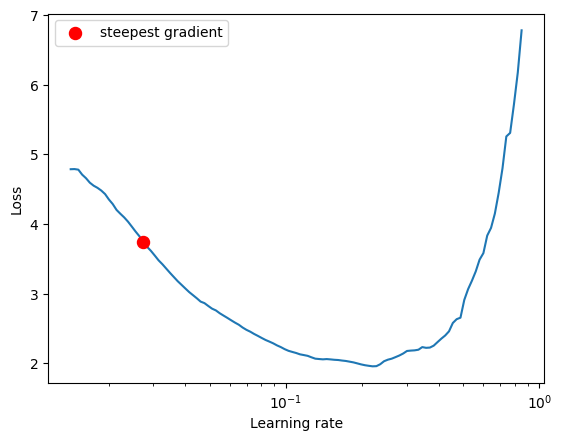

In [8]:
from torch_lr_finder import LRFinder

# #model = CustomResNet().to(device)
optimizer = optim.Adam(model.parameters(), lr= 0.01, weight_decay= 1e-4)
criterion = nn.CrossEntropyLoss()
lr_finder = LRFinder(model, optimizer, criterion, device=device)
lr_finder.range_test(Aug.train_loader, end_lr=10, num_iter=200, step_mode="exp")
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [9]:

#optimizer = optim.Adam(params = model.parameters(), lr = 0.001)
#step_sizes = 8  # Adjust the learning rate after 10, 20, and 30 epochs
gamma = 0.1  # The factor by which the learning rate will be reduced

#scheduler = optim.lr_scheduler.StepLR(optimizer, step_sizes, gamma=gamma, verbose=True)
#scheduler = ReduceLROnPlateau(optimizer, mode='min', patience=2, factor=0.1)
num_epochs = 24

#max_lr=4.38E-02
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=2.74E-02, steps_per_epoch=len(Aug.train_loader), epochs=num_epochs,
                                                pct_start= 5/num_epochs, 
                                                div_factor = 100, 
                                                three_phase= False,
                                                final_div_factor=100,
                                                anneal_strategy = 'linear',
                                                verbose= False)
# New Line

#criterion = nn.CrossEntropyLoss()

#criterion_test = nn.CrossEntropyLoss(reduction='sum')

   
for epoch in range(1, num_epochs+1):
    print(f'Epoch {epoch}')
    train(model, device, Aug.train_loader, optimizer, scheduler,criterion)
    test_loss = test(model, device, Aug.test_loader,criterion)
    #scheduler.step(test_loss)


Epoch 1


Loss=1.096866488456726 Batch_id=97 Accuracy=51.82: 100%|██████████| 98/98 [01:00<00:00,  1.62it/s] 



Test set: Average loss: 0.0020, Accuracy: 6504/10000 (65.04%)

Epoch 2


Loss=0.8355417847633362 Batch_id=97 Accuracy=68.75: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0021, Accuracy: 6608/10000 (66.08%)

Epoch 3


Loss=0.9101064801216125 Batch_id=97 Accuracy=73.05: 100%|██████████| 98/98 [00:58<00:00,  1.66it/s]



Test set: Average loss: 0.0021, Accuracy: 6643/10000 (66.43%)

Epoch 4


Loss=0.5814257860183716 Batch_id=97 Accuracy=76.49: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s]



Test set: Average loss: 0.0018, Accuracy: 6932/10000 (69.32%)

Epoch 5


Loss=0.5636159777641296 Batch_id=97 Accuracy=77.33: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0017, Accuracy: 7286/10000 (72.86%)

Epoch 6


Loss=0.4819396436214447 Batch_id=97 Accuracy=80.07: 100%|██████████| 98/98 [01:27<00:00,  1.12it/s]



Test set: Average loss: 0.0015, Accuracy: 7450/10000 (74.50%)

Epoch 7


Loss=0.664767861366272 Batch_id=97 Accuracy=80.91: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]  



Test set: Average loss: 0.0012, Accuracy: 7973/10000 (79.73%)

Epoch 8


Loss=0.5243217945098877 Batch_id=97 Accuracy=81.97: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s] 



Test set: Average loss: 0.0016, Accuracy: 7428/10000 (74.28%)

Epoch 9


Loss=0.5475736856460571 Batch_id=97 Accuracy=82.23: 100%|██████████| 98/98 [01:02<00:00,  1.57it/s] 



Test set: Average loss: 0.0012, Accuracy: 8003/10000 (80.03%)

Epoch 10


Loss=0.5077096223831177 Batch_id=97 Accuracy=83.16: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s] 



Test set: Average loss: 0.0012, Accuracy: 7923/10000 (79.23%)

Epoch 11


Loss=0.4328717887401581 Batch_id=97 Accuracy=83.45: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s] 



Test set: Average loss: 0.0013, Accuracy: 7979/10000 (79.79%)

Epoch 12


Loss=0.45868176221847534 Batch_id=97 Accuracy=83.71: 100%|██████████| 98/98 [01:45<00:00,  1.07s/it]



Test set: Average loss: 0.0012, Accuracy: 7933/10000 (79.33%)

Epoch 13


Loss=0.39488476514816284 Batch_id=97 Accuracy=84.92: 100%|██████████| 98/98 [00:58<00:00,  1.67it/s]



Test set: Average loss: 0.0013, Accuracy: 7890/10000 (78.90%)

Epoch 14


Loss=0.41366496682167053 Batch_id=97 Accuracy=84.63: 100%|██████████| 98/98 [00:59<00:00,  1.64it/s]



Test set: Average loss: 0.0009, Accuracy: 8412/10000 (84.12%)

Epoch 15


Loss=0.46661412715911865 Batch_id=97 Accuracy=85.60: 100%|██████████| 98/98 [00:58<00:00,  1.68it/s]



Test set: Average loss: 0.0011, Accuracy: 8174/10000 (81.74%)

Epoch 16


Loss=0.47316601872444153 Batch_id=97 Accuracy=86.11: 100%|██████████| 98/98 [00:59<00:00,  1.65it/s]



Test set: Average loss: 0.0009, Accuracy: 8450/10000 (84.50%)

Epoch 17


Loss=0.2960120141506195 Batch_id=97 Accuracy=87.05: 100%|██████████| 98/98 [00:59<00:00,  1.66it/s] 



Test set: Average loss: 0.0009, Accuracy: 8531/10000 (85.31%)

Epoch 18


Loss=0.39808759093284607 Batch_id=97 Accuracy=87.31: 100%|██████████| 98/98 [01:03<00:00,  1.55it/s]



Test set: Average loss: 0.0009, Accuracy: 8567/10000 (85.67%)

Epoch 19


Loss=0.28103044629096985 Batch_id=97 Accuracy=88.47: 100%|██████████| 98/98 [01:02<00:00,  1.58it/s]



Test set: Average loss: 0.0008, Accuracy: 8621/10000 (86.21%)

Epoch 20


Loss=0.32788750529289246 Batch_id=97 Accuracy=89.51: 100%|██████████| 98/98 [01:01<00:00,  1.59it/s]



Test set: Average loss: 0.0008, Accuracy: 8615/10000 (86.15%)

Epoch 21


Loss=0.23448514938354492 Batch_id=97 Accuracy=90.59: 100%|██████████| 98/98 [01:02<00:00,  1.58it/s]



Test set: Average loss: 0.0006, Accuracy: 8958/10000 (89.58%)

Epoch 22


Loss=0.25261566042900085 Batch_id=97 Accuracy=92.10: 100%|██████████| 98/98 [01:01<00:00,  1.58it/s]



Test set: Average loss: 0.0006, Accuracy: 9076/10000 (90.76%)

Epoch 23


Loss=0.22335761785507202 Batch_id=97 Accuracy=93.78: 100%|██████████| 98/98 [01:02<00:00,  1.58it/s]



Test set: Average loss: 0.0005, Accuracy: 9156/10000 (91.56%)

Epoch 24


Loss=0.1389889121055603 Batch_id=97 Accuracy=95.43: 100%|██████████| 98/98 [01:02<00:00,  1.58it/s] 



Test set: Average loss: 0.0005, Accuracy: 9233/10000 (92.33%)



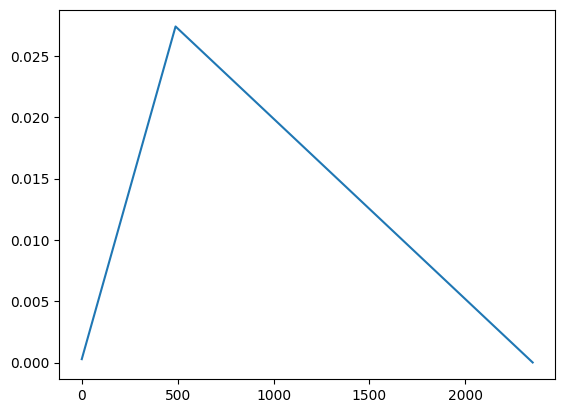

In [10]:
len(lrs)
plt.plot(lrs)

In [12]:
model = models.model()
summary(model, input_size=(3, 32, 32))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,728
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,728
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
             ReLU-10          [-1, 128, 16, 16]               0
           Conv2d-11          [-1, 128, 16, 16]         147,456
      BatchNorm2d-12          [-1, 128, 16, 16]             256
             ReLU-13          [-1, 128, 16, 16]               0
           Conv2d-14          [-1, 256,